In [ ]:
# On trace la trajectoire (d,t) et (x,y) du véhicule ego et des véhicules
# qui l'entourent en mettant des numéros sur les trajectoires des véhicules
# pour savoir si les trajectoires sont cohérentes entre elles

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/tiffanydarini/nuscenes-devkit/python-sdk/tutorials/data/sets/nuscenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.350 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
# Fonction qui renvoie les tables ego_pose d'une scène donnée
def get_poses(scene_token):
    pose_list = []
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    
    ego_pose = nusc.get('ego_pose', sd_rec['token'])
    pose_list.append(ego_pose)

    while sd_rec['next'] != '':
        sd_rec = nusc.get('sample_data', sd_rec['next'])
        ego_pose = nusc.get('ego_pose', sd_rec['token'])
        pose_list.append(ego_pose)

    return pose_list

In [3]:
# On crée une fonction qui renvoie la liste des rangs dans les listes X,Y des objets immobiles de 
# cette liste et donc d'une même catégorie, ainsi que la liste des objets mobiles 

def immobile(X,Y):
    Immo = []
    Mobile = []
    n = len(X) # Nombre d'élément dans la catégorie 
    for i in range(0,n-1):
        X_coord = X[i]
        Y_coord = Y[i]
        if len(X_coord)==1 :
            Immo.append(i)
        else : 
            d = 0 
            for k in range(0,len(X_coord)-1):
                d+= sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2)
            if d<2 : # Si la distance totale parcourue par l'objet est inférieur à 2m, on considère que l'objet bouge pas
                Immo.append(i)
            else :
                Mobile.append(i)
    return Immo,Mobile

# Trajectoire dans le plan (x,y)

In [4]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta

def traj_ego_veh(scene_name):
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
    # Lieu de départ du véhicule ego
    X1 = X_coord[0]
    Y1 = Y_coord[0]
    
    # On crée les listes de distances et de temps 
    D =[0]
    T=[0]
    for k in range(0,len(T_timestamp)-1):
        D.append(D[k]+sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2+(Z_coord[k+1]-Z_coord[k])**2))
        t2 = datetime.datetime.fromtimestamp(T_timestamp[k+1]/ 1e6) # on met les timestamp en datetime
        t1 = datetime.datetime.fromtimestamp(T_timestamp[k]/ 1e6)
        t = T[k]+(t2-t1).total_seconds() # On récupère le temps en seconde 
        T.append(t)
    
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    # On crée une liste de 10 couleurs car il y a au maximum 10 catégories de véhicules 
    c = ['g','darkorange','firebrick','c','indigo','hotpink','olive','grey','rosybrown','chartreuse']
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        couleur_catego = c[j]
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        for k in L :
            x = []
            y = []
            z = []
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
            X.append(x)
            Y.append(y)
            Z.append(z)
                    
        fig = plt.figure(1, figsize=(10, 10))
 
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # Courbe (X,Y)
        if len(Mobile)==1 :
            plt.plot(X[Mobile[0]],Y[Mobile[0]],label=catego_name,color=couleur_catego)
            plt.text(X[Mobile[0]][0], Y[Mobile[0]][0],'1', fontsize=18,color=couleur_catego)

        elif len(Mobile)>1 :
            plt.plot(X[Mobile[0]],Y[Mobile[0]],label=catego_name,color=couleur_catego)
            plt.text(X[Mobile[0]][0], Y[Mobile[0]][0],'1', fontsize=18,color=couleur_catego)
            for i in range(1,len(Mobile)):
                plt.plot(X[Mobile[i]],Y[Mobile[i]],color=couleur_catego)
                plt.text(X[Mobile[i]][0], Y[Mobile[i]][0],str(i+1),fontsize=18,color=couleur_catego)
                    
    plt.plot(X1,Y1,'x',label='Départ',color='r')
    plt.plot(X_coord,Y_coord,label ='Trajectoire véhicule ego',color='cornflowerblue')
    plt.legend(bbox_to_anchor=(1.5, 1.0),loc='best')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajectoire des éléments dans la '+ scene_name)
    plt.show()


### Test sur plusieurs scènes 

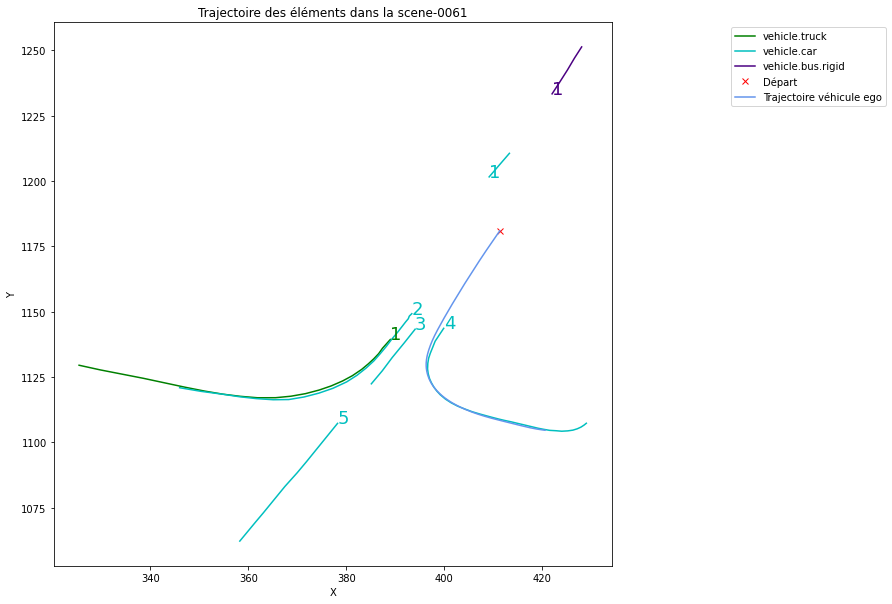

In [5]:
scene_name = 'scene-0061'
traj_ego_veh(scene_name)

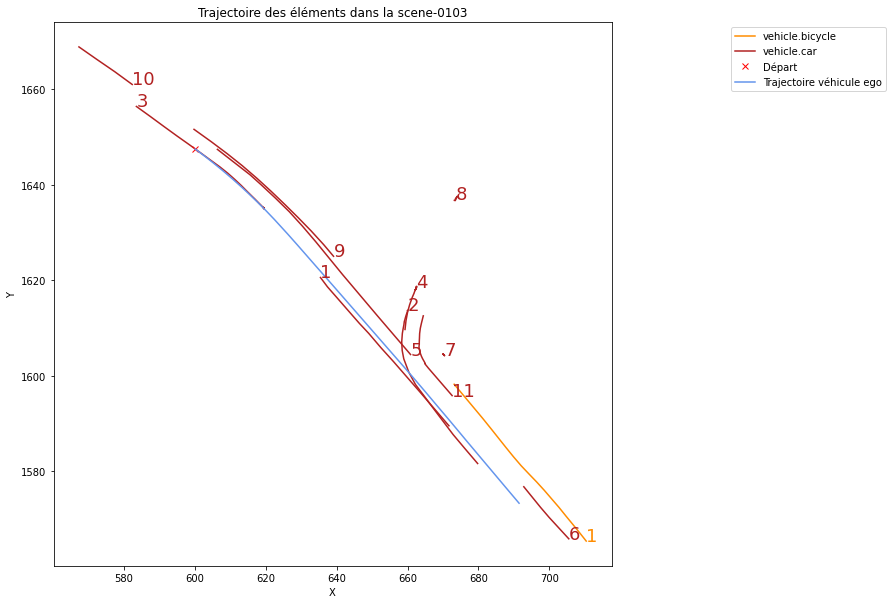

In [6]:
# scene-0103
scene_name = 'scene-0103'
traj_ego_veh(scene_name)

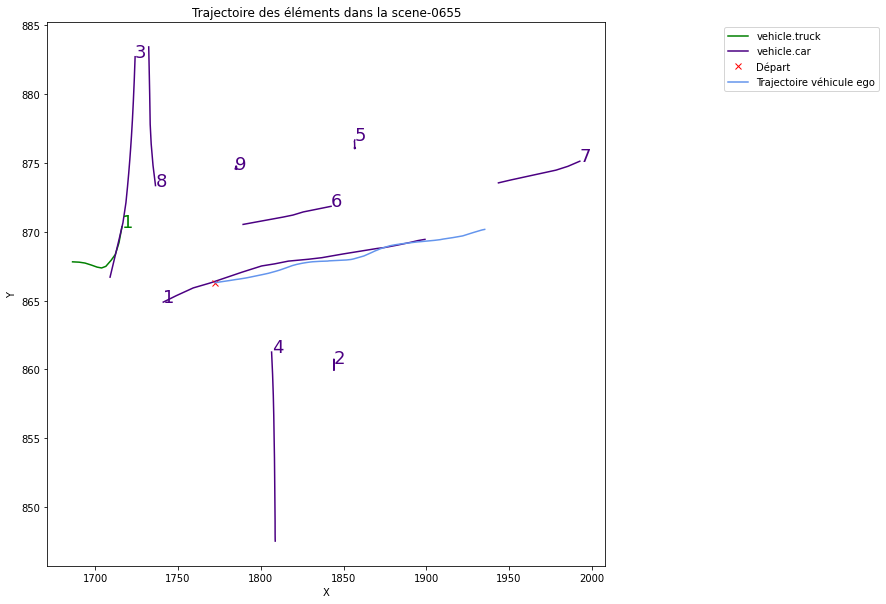

In [7]:
# scene-0655
scene_name = 'scene-0655'
traj_ego_veh(scene_name)

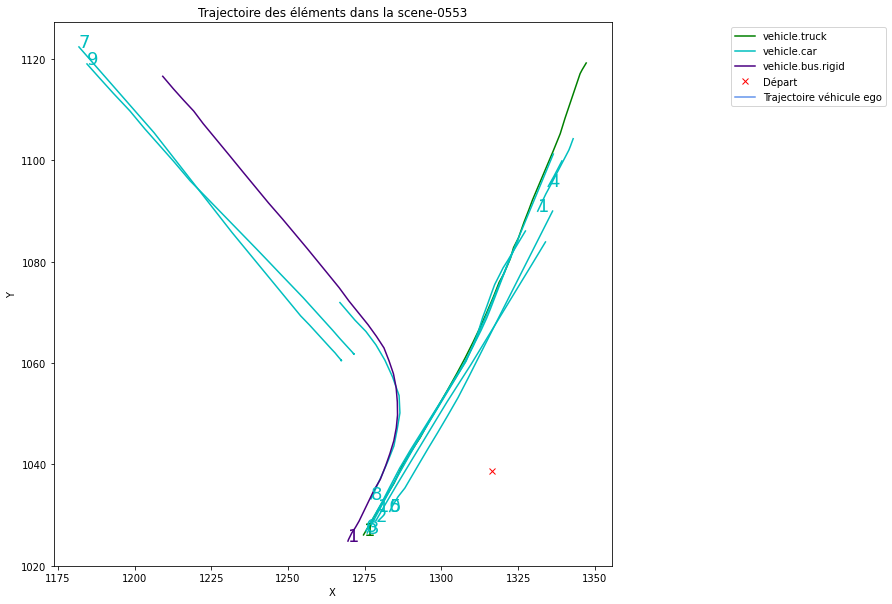

In [8]:
# scene-0553
scene_name = 'scene-0553'
traj_ego_veh(scene_name)

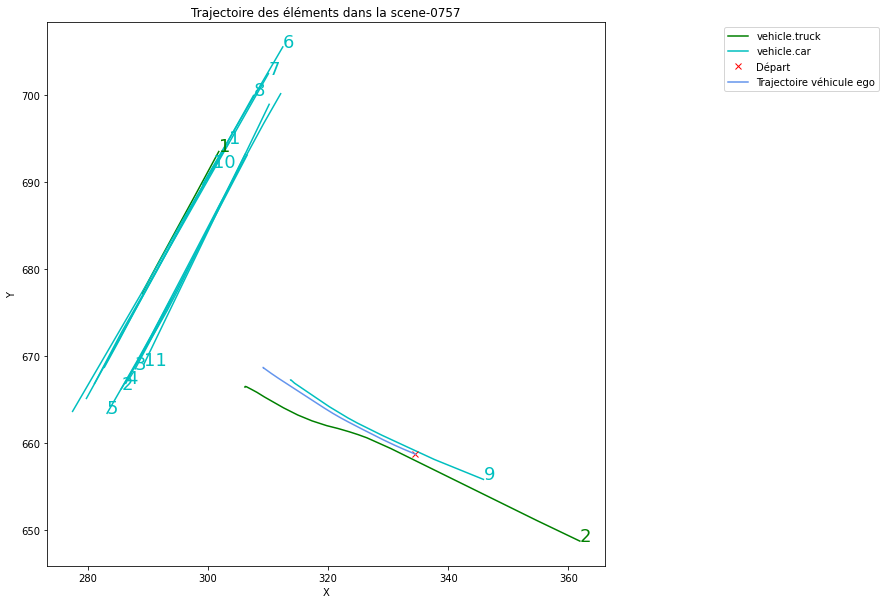

In [9]:
# scene-0757
scene_name = 'scene-0757'
traj_ego_veh(scene_name)

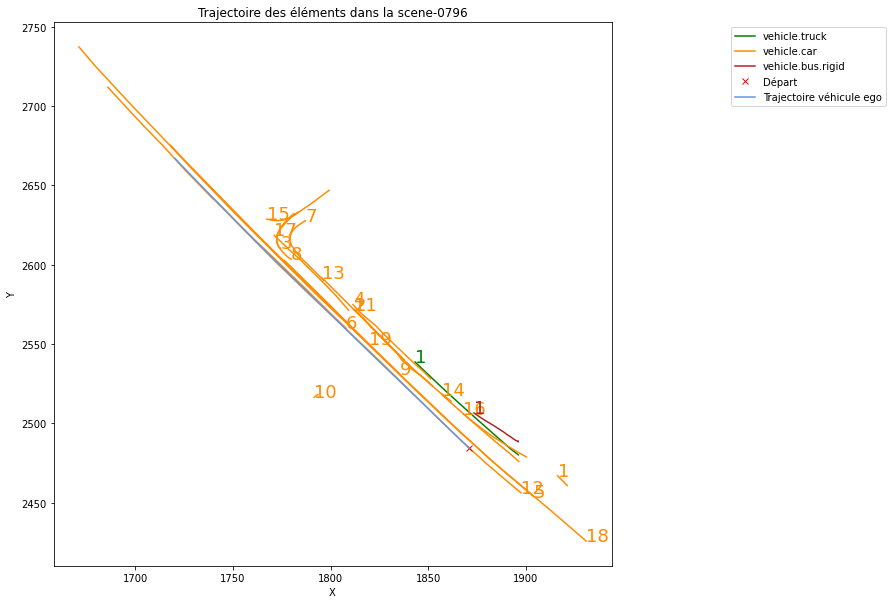

In [10]:
# scene-0796
scene_name = 'scene-0796'
traj_ego_veh(scene_name)

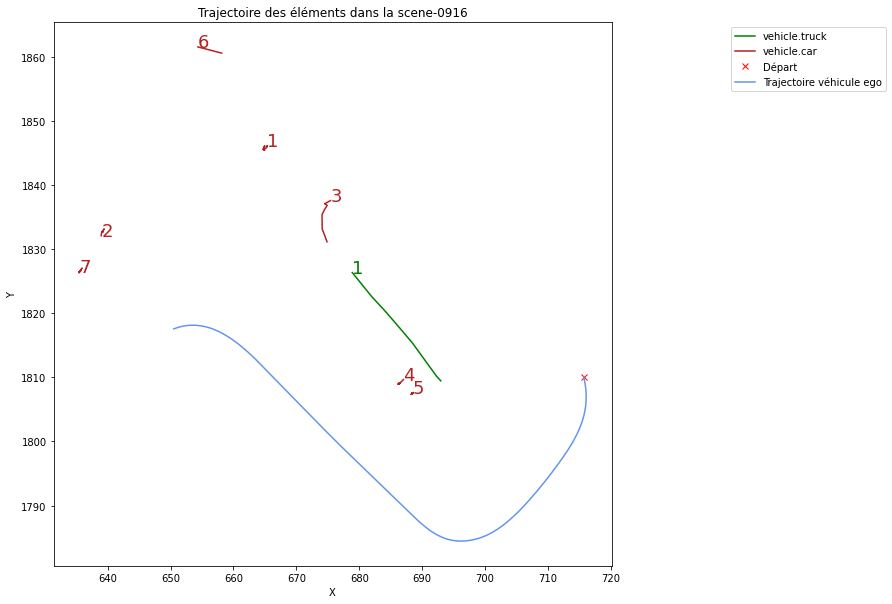

In [11]:
# scene-0916
scene_name = 'scene-0916'
traj_ego_veh(scene_name)

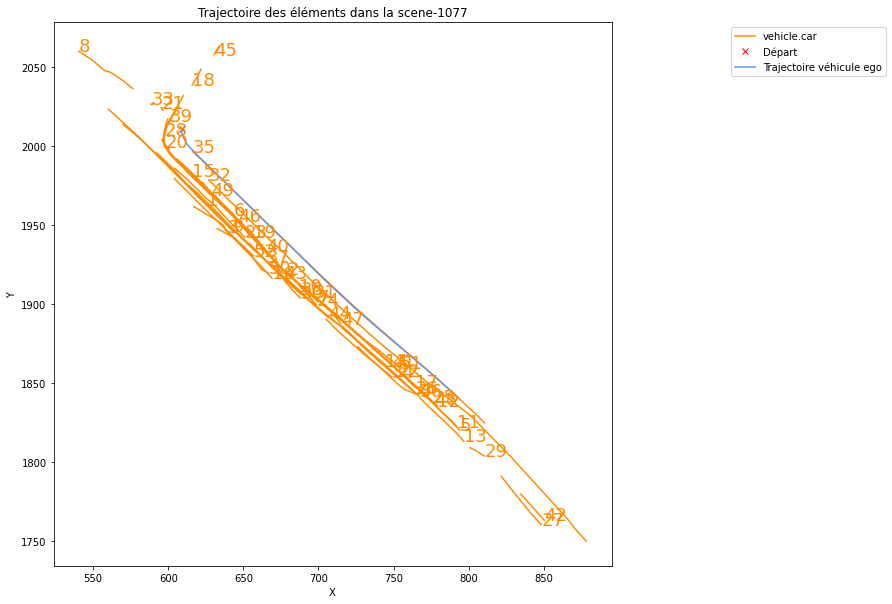

In [12]:
# scene-1077
scene_name = 'scene-1077'
traj_ego_veh(scene_name)

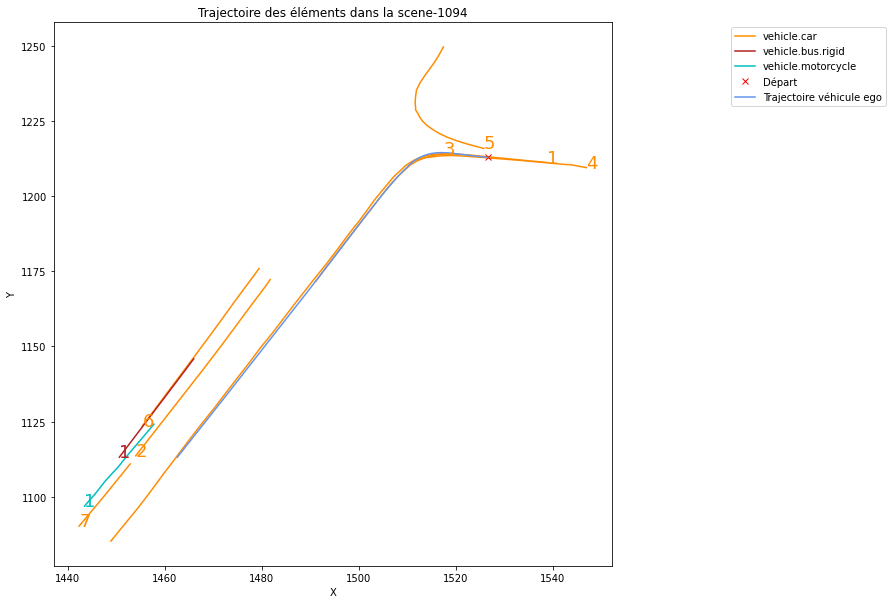

In [13]:
# scene-1094
scene_name = 'scene-1094'
traj_ego_veh(scene_name)

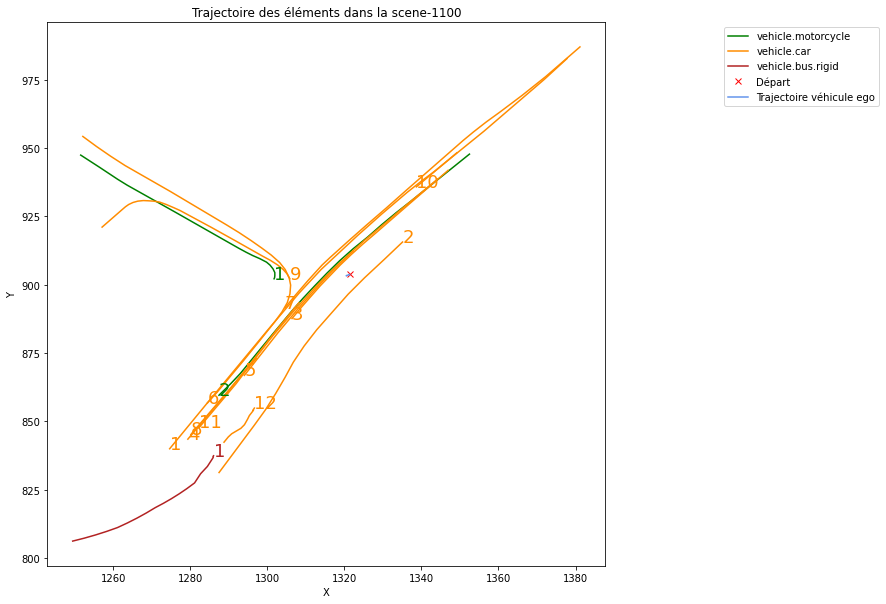

In [14]:
# scene-1100
scene_name = 'scene-1100'
traj_ego_veh(scene_name)

# Trajectoire dans le plan (t,d)

In [15]:
import numpy as np

def suiveur(X_ego,Y_ego,X_veh,Y_veh):
    V1 = np.array([X_ego[0]-X_veh[0],Y_ego[0]-Y_veh[0]])
    V2 = np.array([X_veh[1]-X_veh[0],Y_veh[1]-Y_veh[0]])
    PC = np.vdot(V1,V2)
    if PC >0 :
        return 0 # Le véhicule suit le véhicule ego
    elif PC<0 :
        return 1 # Le véhicule ego suit le véhicule
    else : 
        return 2 # On est parallèle au départ 
    
# La fonction permet de savoir si un véhicule donné dans la scène suit ou non le véhicule ego à partir des coordonnées
# des deux véhicules dans l'espace. La fonction renvoie :
# - 0 si le véhicule suit le véhicule ego
# - 1 si le vehicule est suivit pas le véhicule égo 
# - 2 si les véhicules sont parallèles au départ

In [16]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta

def dyna_ego_veh_num(scene_name):
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # On crée les listes de distances et de temps 
    D =[0]
    T=[0]
    for k in range(0,len(T_timestamp)-1):
        D.append(D[k]+sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2+(Z_coord[k+1]-Z_coord[k])**2))
        t2 = datetime.datetime.fromtimestamp(T_timestamp[k+1]/ 1e6) # on met les timestamp en datetime
        t1 = datetime.datetime.fromtimestamp(T_timestamp[k]/ 1e6)
        t = T[k]+(t2-t1).total_seconds() # On récupère le temps en seconde 
        T.append(t)
    
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
    
    

    # On crée une liste de 10 couleurs car il y a au maximum 10 catégories de véhicules 
    c = ['g','darkorange','firebrick','c','indigo','hotpink','olive','grey','rosybrown','chartreuse']
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        couleur_catego = c[j]
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t = []
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
        
        D_catego =[]
        T_catego =[]
        
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        for j in Mobile :
           
            if T_timestamp[0] == T_time[j][0] : # Même t départ avec le véhicule ego :
                d0 = sqrt((X[j][0]-X_coord[0])**2+(Y[j][0]-Y_coord[0])**2+(Z[j][0]-Z_coord[0])**2)
                t_time = [0]
                
                # On regarde si le véhicule suit ou non le véhicule égo pour connaître le signe de d0 
                if suiveur(X_coord,Y_coord,X[j],Y[j]) == 0 :
                    d = [-d0]
                elif suiveur(X_coord,Y_coord,X[j],Y[j]) == 1 :
                    d = [d0]
                else :
                    d = [d0] # ? 
            
            else : # t de départ différent avec le véhicule ego 
    
                # Décalage dans le temps
                t_time = [(datetime.datetime.fromtimestamp(T_time[j][0]/ 1e6) - datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()]
    
                # Décalage dans l'espace 
                e = T_timestamp.index(T_time[j][0])
                # Avec e l'indice du timestamp du véhicule égo pour lequel le timestamp correspondant est égal au premier timestamp de l'élément de la catégorie
                d0 = sqrt((X[j][0]-X_coord[e])**2+(Y[j][0]-Y_coord[e])**2+(Z[j][0]-Z_coord[e])**2)
               
                # On regarde si le véhicule suit ou non le véhicule égo pour connaître le signe de d0 
                if suiveur(X_coord,Y_coord,X[j],Y[j]) == 0 :
                    d = [-d0]
                elif suiveur(X_coord,Y_coord,X[j],Y[j]) == 1 :
                    d = [d0]
                else :
                    d = [d0]
                    
            for k in range(0,len(X[j])-1):
                d.append(d[k]+sqrt((X[j][k+1]-X[j][k])**2+(Y[j][k+1]-Y[j][k])**2+(Z[j][k+1]-Z[j][k])**2))
                t2 = datetime.datetime.fromtimestamp(T_time[j][k+1]/ 1e6) # on met les timestamp en datetime
                t1 = datetime.datetime.fromtimestamp(T_time[j][k]/ 1e6)
                t = t_time[k]+(t2-t1).total_seconds() # On récupère le temps en seconde 
                t_time.append(t)
            D_catego.append(d)
            T_catego.append(t_time)
        
        fig = plt.figure(1, figsize=(10, 10))
        
        if len(Mobile)==1 :
            plt.plot(T_catego[0],D_catego[0],label=catego_name,color=couleur_catego)
            plt.text(T_catego[0][0], D_catego[0][0],'1', fontsize=18,color=couleur_catego)
        elif len(Mobile)>1:
            plt.plot(T_catego[0],D_catego[0],label=catego_name,color=couleur_catego)
            plt.text(T_catego[0][0], D_catego[0][0],'1', fontsize=18,color=couleur_catego)
            for i in range(1,len(Mobile)):
                plt.plot(T_catego[i],D_catego[i],color=couleur_catego)
                plt.text(T_catego[i][0],D_catego[i][0],str(i+1),fontsize=18,color=couleur_catego)

    # On trace 
    plt.plot(T,D,label ='Trajectoire véhicule ego',color='cornflowerblue')
    plt.xlabel('Temps (en s)') 
    plt.ylabel('Distance parcourue (en m)') # Les x,y,z sont en m 
    plt.legend(bbox_to_anchor=(1.5, 1.0),loc='best')
    plt.title("Distance en fonction du temps du véhicule ego et des éléments qui l'entourent dans la "+scene_name)
    plt.show()


### Test sur plusieurs scènes

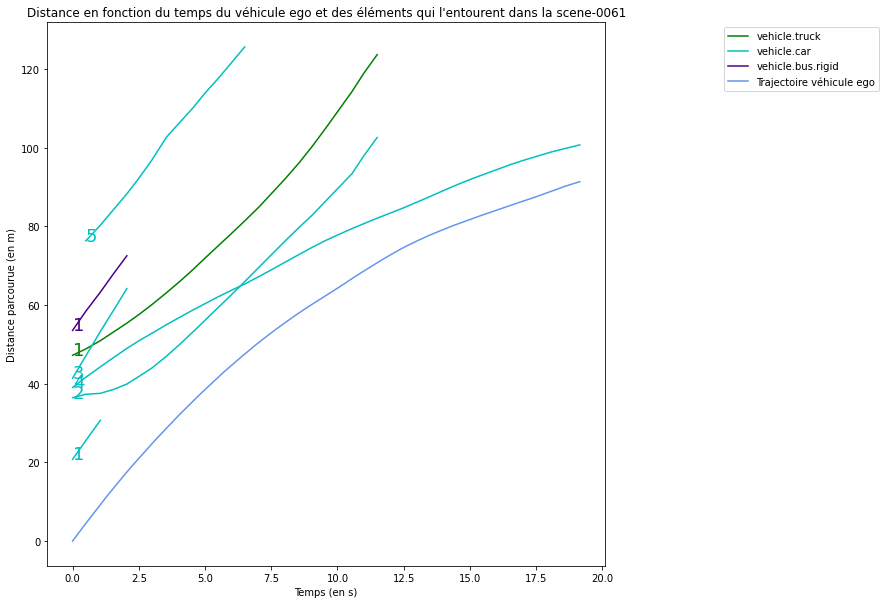

In [17]:
scene_name = 'scene-0061'
dyna_ego_veh_num(scene_name)

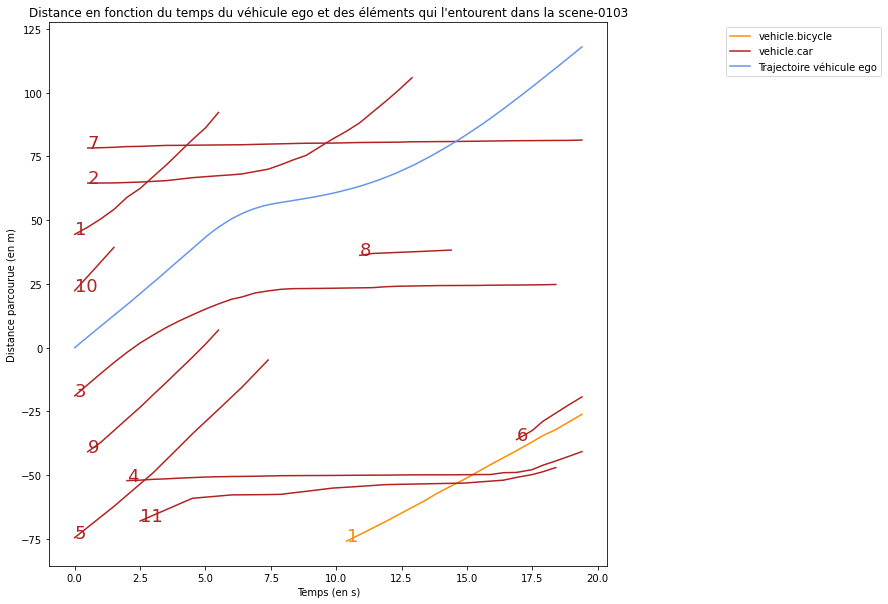

In [18]:
# scene-0103
scene_name = 'scene-0103'
dyna_ego_veh_num(scene_name)

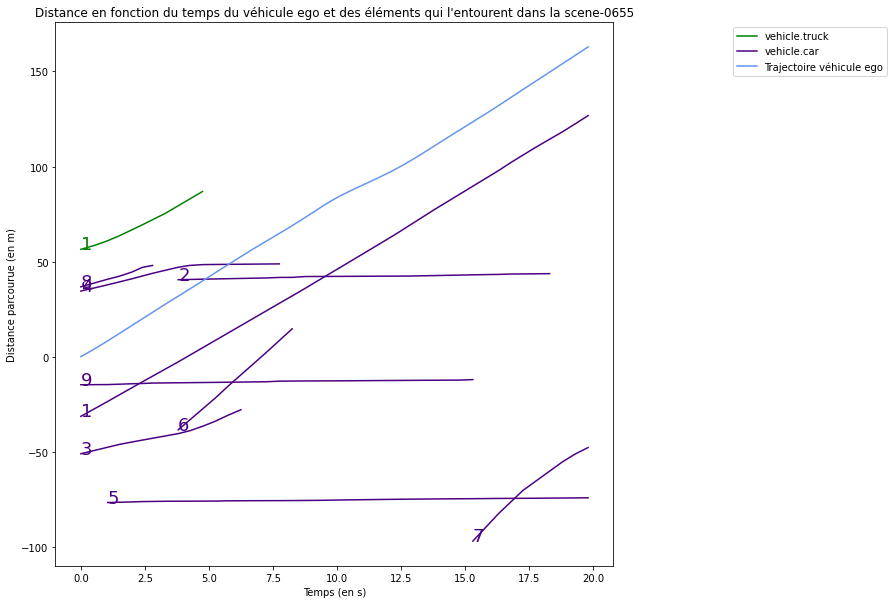

In [19]:
# scene-0655
scene_name = 'scene-0655'
dyna_ego_veh_num(scene_name)

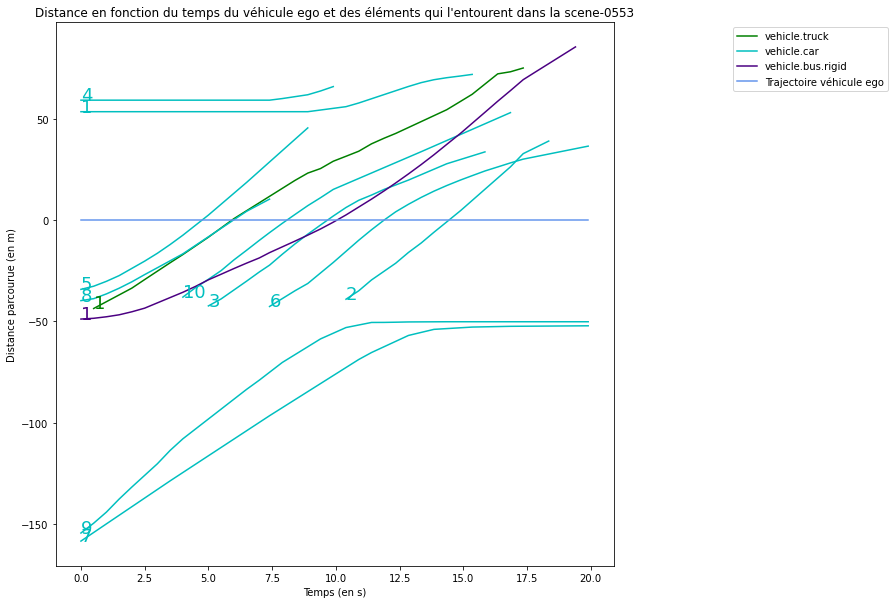

In [20]:
# scene-0553
scene_name = 'scene-0553'
dyna_ego_veh_num(scene_name)

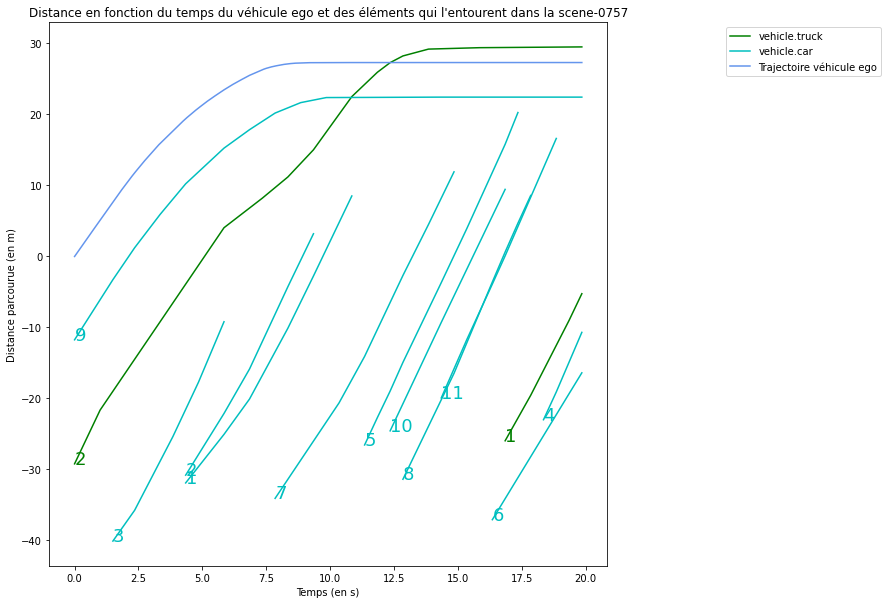

In [21]:
# scene-0757
scene_name = 'scene-0757'
dyna_ego_veh_num(scene_name)

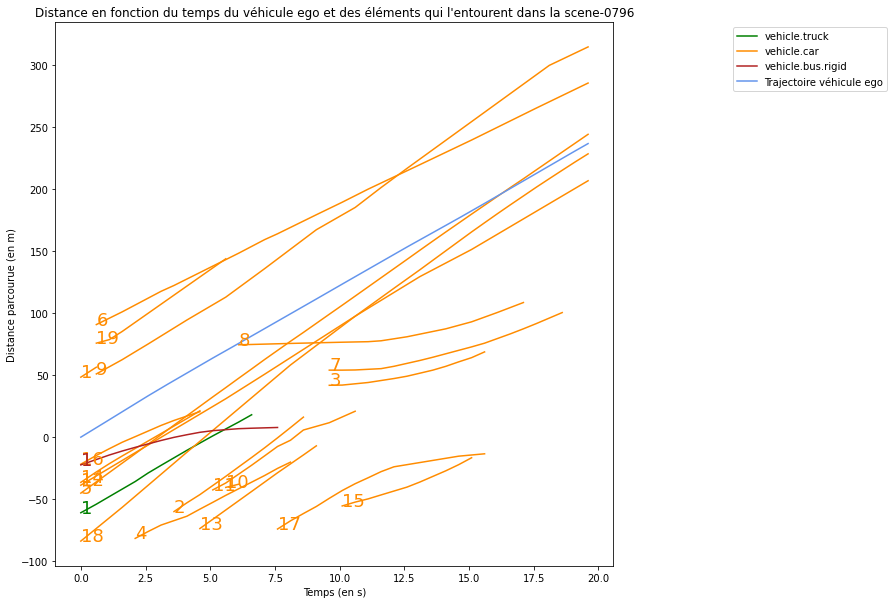

In [22]:
# scene-0796
scene_name = 'scene-0796'
dyna_ego_veh_num(scene_name)

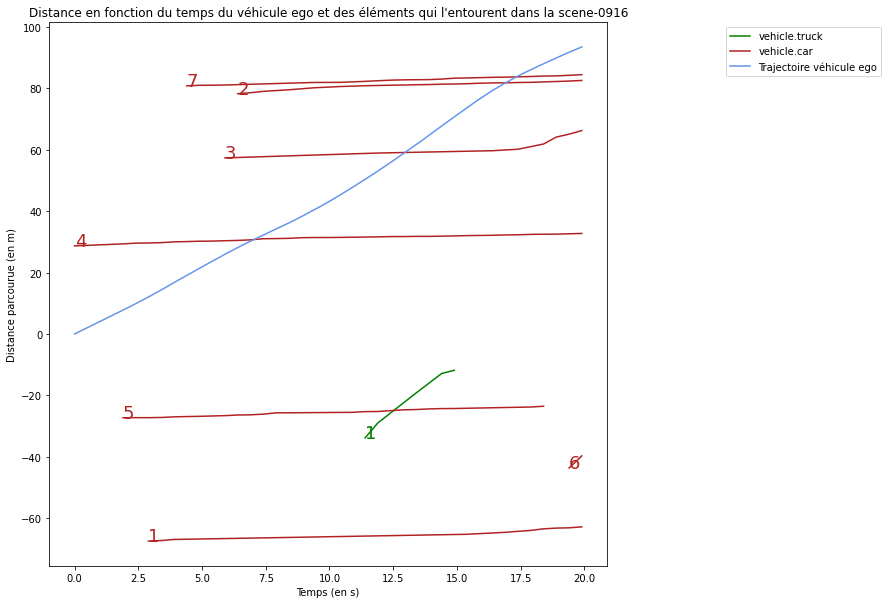

In [23]:
# scene-0916
scene_name = 'scene-0916'
dyna_ego_veh_num(scene_name)

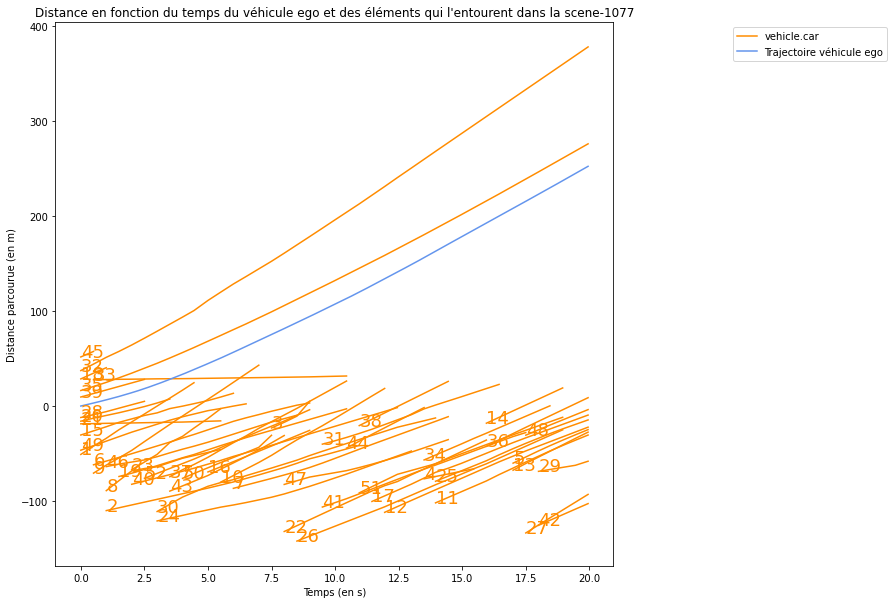

In [24]:
# scene-1077
scene_name = 'scene-1077'
dyna_ego_veh_num(scene_name)

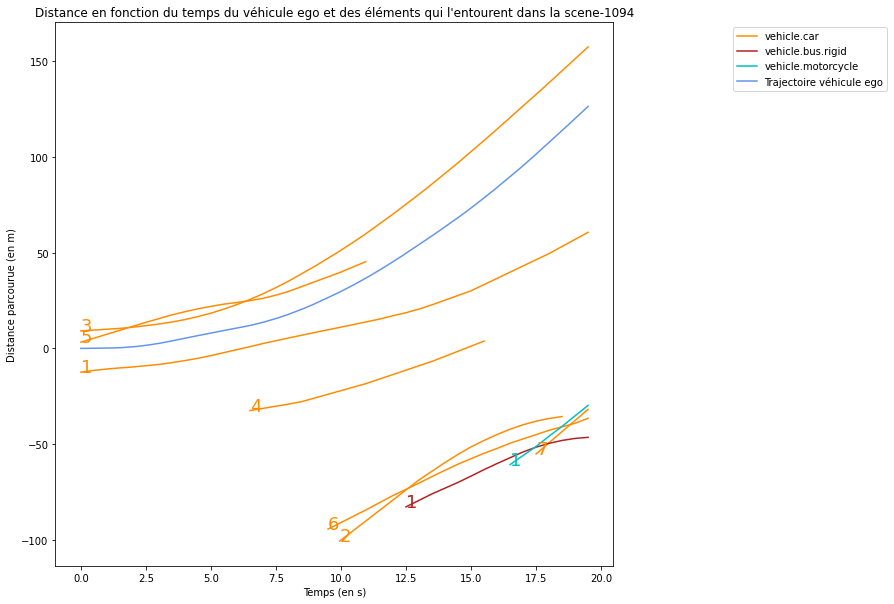

In [25]:
# scene-1094
scene_name = 'scene-1094'
dyna_ego_veh_num(scene_name)

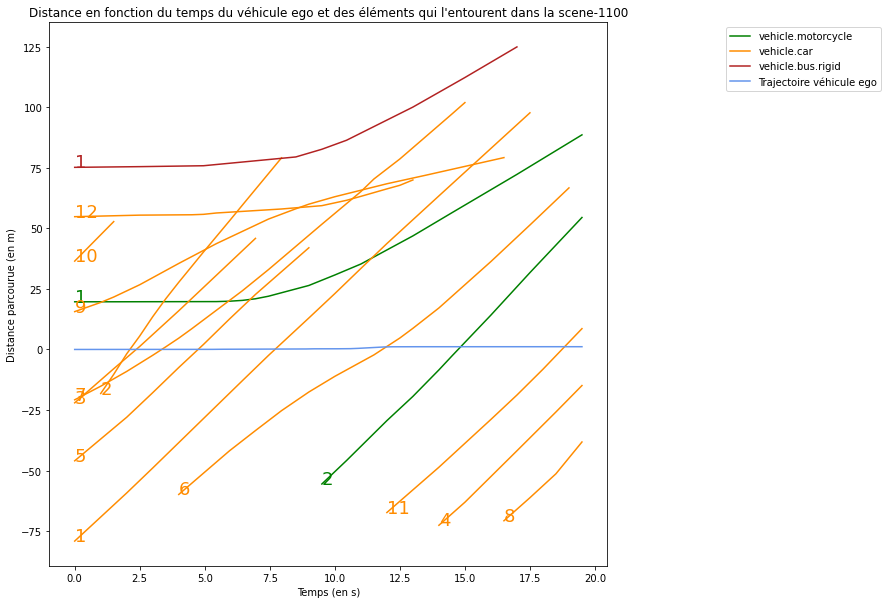

In [26]:
# scene-1100
scene_name = 'scene-1100'
dyna_ego_veh_num(scene_name)